<h1 align="center">Introduction to Machine Learning - 25737-2</h1>
<h4 align="center">Dr. R. Amiri</h4>
<h4 align="center">Sharif University of Technology, Spring 2024</h4>


<link rel="preconnect" href="https://fonts.googleapis.com">
<link rel="preconnect" href="https://fonts.gstatic.com" crossorigin>
<link href="https://fonts.googleapis.com/css2?family=Titillium+Web:ital,wght@0,200;0,300;0,400;0,600;0,700;0,900;1,200;1,300;1,400;1,600;1,700&display=swap" rel="stylesheet">
<div class="box" style="padding: 10px; margin: 10px 0; background-color: gray; color: white; border-radius: 5px; font-size: 15px;">
  <table style="padding: 10px; margin: auto auto; background-color: gray;  border-radius: 5px; font-size: 15px;">
      <tr>
          <th colspan='2'><h1 style="text-align: center">
Machine Learning </br>
</h1>
<h2 style="text-align: center">
Course Assignment Two </br>
</h2>
</th>
<tr>
    <tr>
      <th colspan="2">Personal Info</th>
    </tr>
    <tr>
      <td>First Name:</td>
      <td>Ali</td>
    </tr>
    <tr>
      <td>Last Name:</td>
      <td>Nikkhah</td>
    </tr>
    <tr>
      <td>Student Number:</td>
      <td>99102445</td>
    </tr>
    <tr>
      <td>Github:</td>
      <td><a href="https://github.com/AliNikkhah2001/MachineLearning02" target="_blank">https://github.com/AliNikkhah2001/MachineLearning02</a></td>
    </tr>
  </table>
</div>



In [1]:
%%capture
!pip install numpy
!pip install matplotlib
!pip install torchvision
!pip install torch

## Importing Libraries

In [2]:
import torch
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torch.utils.data import DataLoader

import numpy as np
from matplotlib import pyplot as plt
from typing import Dict

There was a problem when trying to write in your cache folder (/Users/alinikkhah/.cache/huggingface/hub). You should set the environment variable TRANSFORMERS_CACHE to a writable directory.


## Datasets and Dataloaders

Here, we download and load the train and test `FashionMNIST` dataset with the desired transforms. Then, we define the dataloaders for `train` and `test`.

In [3]:
train_set = FashionMNIST(root='.', train=True, download=True, transform=transforms.ToTensor())
test_set = FashionMNIST(root='.', train=False, download=True, transform=transforms.ToTensor())


Here you have to calculate the number of classes amd input dimention of the first layer (how many pixels does each image have?).

In [4]:
# Calculate the input dimension (assuming images are square and grayscale)
input_dim = train_set[0][0].shape[1] * train_set[0][0].shape[2]

# Calculate the number of unique classes
num_classes = len(train_set.classes)

print("Input Dimension:", input_dim)
print("Number of Classes:", num_classes)

Input Dimension: 784
Number of Classes: 10


In [5]:
train_loader = DataLoader(train_set, 64, shuffle=True)
test_loader = DataLoader(test_set, 64, shuffle=True)

## Visualization

Visualize 1 random image from each class by using `plt.subplots`

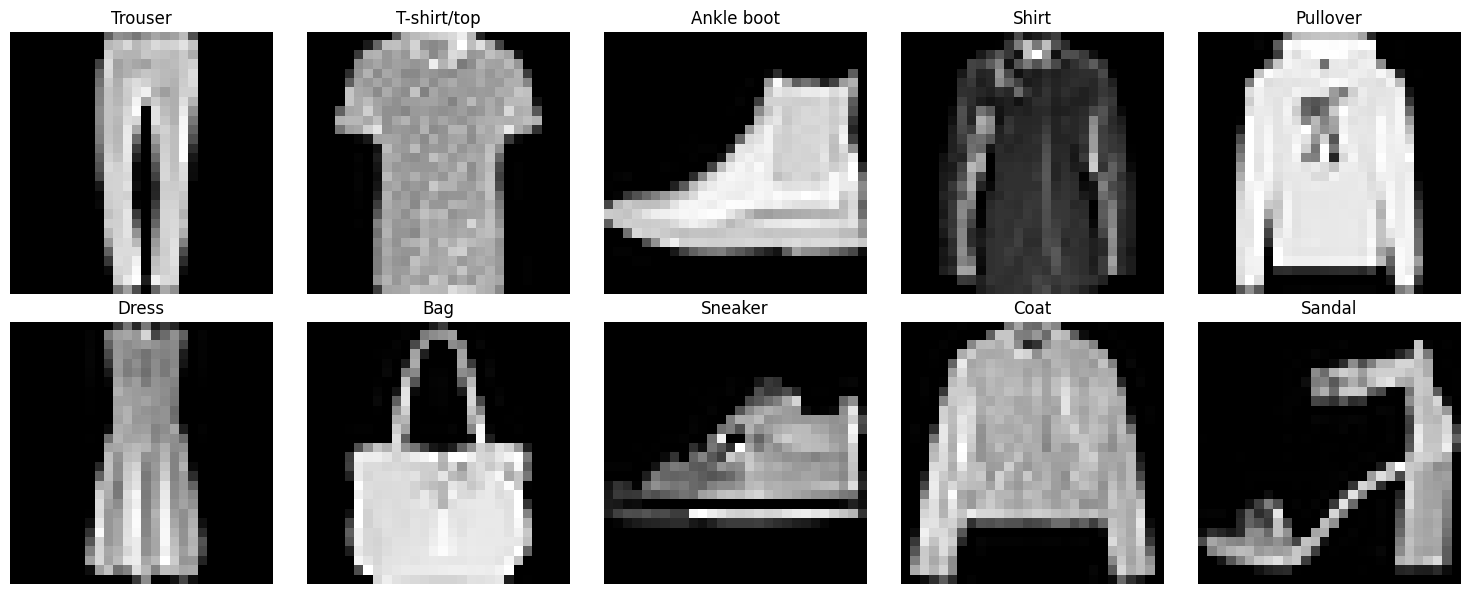

In [6]:
# Load the dataset
dataset = FashionMNIST(root='.', train=True, download=True, transform=transforms.ToTensor())

# Function to display images
def imshow(img, ax, title=None):
    img = img.numpy().squeeze()
    ax.imshow(img, cmap='gray')
    if title is not None:
        ax.set_title(title)
    ax.axis('off')

# Prepare the plot
fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # Setting up the subplots grid
axes = axes.flatten()

# Select one random image per class
class_images = {}
for images, labels in torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True):
    label = labels.item()
    if label not in class_images:
        class_images[label] = images
    if len(class_images) == 10:  # Stop when we have one image per class
        break

# Plot the images
for i, (label, img) in enumerate(class_images.items()):
    imshow(img.squeeze(), axes[i], title=dataset.classes[label])

plt.tight_layout()
plt.show()

## Initializing model's parameters

In this part, we create the model and initialize its parameters and store the values of these parameters in the variable `parameters` which is a dictionary including the weigths and biases of each layer.

In [44]:
def add_linear_layer(parameters: dict, shape, device, i=None):
    """
    This function adds parameters of a linear unit of shape `shape` to the `parameters` dictionary.
    """
    n_in, n_out = shape
    with torch.no_grad():


        w = torch.zeros(*shape, device=device)
        # kaiming initialization for ReLU activations:
        bound = 1 / np.sqrt(n_in).item()
        w.uniform_(-bound, bound)
        b = torch.zeros(n_out, device=device)  # no need to (1, n_out). it will broadcast itself.
    w.requires_grad = True
    b.requires_grad = True
    # `i` is used to give numbers to parameter names
    parameters.update({f'w{i}': w, f'b{i}': b})

Now we define our neural network with the given layers and add the weights and biases to the dictionary `parameters`. **You are allowed to modify the values of the layers**.

In [45]:
# input_dim : input dimention of the first layer, which you have calculated before.
layers = [
    (input_dim, 512),
    (512, 256),
    (256, 128),
    (128, 64),
    (64, num_classes)
]
num_layers = len(layers)
parameters = {}

# setting the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# adding the parameters to the dictionary
for i, shape in enumerate(layers):
    add_linear_layer(parameters, shape, device, i)

parameters.keys()

dict_keys(['w0', 'b0', 'w1', 'b1', 'w2', 'b2', 'w3', 'b3', 'w4', 'b4'])

## Defining the required functions

In this section, we should define the required functions. For each of these functions, the inputs and the desired outputs are given and you should write all or part of the function. **You are not allowed to use the activation functions and the loss functions implemented in torch**.

Computing affine and relu outputs:

In [46]:
def affine_forward(x, w, b):
    return torch.mm(x, w) + b

def relu(x):
    return torch.maximum(x, torch.tensor(0.0, device=x.device))


Function `model` returns output of the whole model for the input `x` using the parameters:

In [47]:
def model(x, parameters, num_layers=num_layers):
    # Flatten the input if it's not already a 2D tensor
    if x.dim() > 2:
        x = x.view(x.size(0), -1)  # Reshape x to [batch_size, feature_dim]
    
    for i in range(num_layers):
        x = affine_forward(x, parameters[f'w{i}'], parameters[f'b{i}'])
        if i < num_layers - 1:  # Apply ReLU to all but the output layer
            x = relu(x)
    return x


Implementing cross entropy loss:

In [48]:
def cross_entropy_loss(scores, y):
    scores_stable = scores - scores.max(dim=1, keepdim=True).values  # Avoid in-place operation
    exp_scores = torch.exp(scores_stable)
    sum_exp_scores = exp_scores.sum(dim=1, keepdim=True)
    softmax_scores = exp_scores / sum_exp_scores
    correct_log_probs = -torch.log(softmax_scores[range(len(y)), y])
    loss = correct_log_probs.mean()
    return loss


Implementing a function for optimizing paramters and a function to zeroing out their gradients:

In [49]:
def sgd_optimizer(parameters, learning_rate=0.001):
    for param in parameters.values():
        param.data -= learning_rate * param.grad
        param.grad.zero_()


Training functions:

In [50]:
def accuracy(y_pred, y_true):
    return (y_pred == y_true).mean()


def train(train_loader, parameters, learning_rate=0.001, epoch=None):
    train_loss = 0
    Y = []
    Y_pred = []

    for i, (x, y) in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device)
        p = model(x, parameters)

        loss = cross_entropy_loss(p, y)
        train_loss += loss.item()
        loss.backward()

        sgd_optimizer(parameters, learning_rate)

        y_pred = p.argmax(dim=-1)
        Y.append(y.cpu().numpy())
        Y_pred.append(y_pred.cpu().numpy())

    Y = np.concatenate(Y)
    Y_pred = np.concatenate(Y_pred)
    acc = accuracy(Y_pred, Y)
    print(f'Epoch {epoch}, Train loss: {train_loss / len(train_loader)}, Accuracy: {acc}')
    return train_loss/len(train_loader), acc

def validate(loader, parameters, epoch=None, set_name='Validation'):
    total_loss = 0
    Y = []
    Y_pred = []

    for i, (x, y) in enumerate(loader):
        x = x.to(device)
        y = y.to(device)
        p = model(x, parameters)

        loss = cross_entropy_loss(p, y)
        total_loss += loss.item()

        y_pred = p.argmax(dim=-1)
        Y.append(y.cpu().numpy())
        Y_pred.append(y_pred.cpu().numpy())

    Y = np.concatenate(Y)
    Y_pred = np.concatenate(Y_pred)
    acc = accuracy(Y_pred, Y)
    print(f'Epoch {epoch}, {set_name} loss: {total_loss / len(loader)}, Accuracy: {acc}')
    return total_loss / len(loader), acc


In [51]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [52]:
def train(train_loader, parameters, learning_rate=0.001, epoch=None):
    train_loss = 0
    Y = []
    Y_pred = []

    for i, (x, y) in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device)
        p = model(x, parameters)

        loss = cross_entropy_loss(p, y)
        train_loss += loss.item()
        loss.backward()

        sgd_optimizer(parameters, learning_rate)

        y_pred = p.argmax(dim=-1)
        Y.append(y.cpu().numpy())
        Y_pred.append(y_pred.cpu().numpy())

    Y = np.concatenate(Y)
    Y_pred = np.concatenate(Y_pred)
    acc = accuracy(Y_pred, Y)
    average_loss = train_loss / len(train_loader)  # Correct average loss calculation
    print(f'Epoch {epoch}, Train loss: {average_loss}, Accuracy: {acc}')
    return average_loss, acc

def validate(loader, parameters, epoch=None, set_name='Validation'):
    total_loss = 0
    Y = []
    Y_pred = []

    for i, (x, y) in enumerate(loader):
        x = x.to(device)
        y = y.to(device)
        p = model(x, parameters)

        loss = cross_entropy_loss(p, y)
        total_loss += loss.item()

        y_pred = p.argmax(dim=-1)
        Y.append(y.cpu().numpy())
        Y_pred.append(y_pred.cpu().numpy())

    Y = np.concatenate(Y)
    Y_pred = np.concatenate(Y_pred)
    acc = accuracy(Y_pred, Y)
    average_loss = total_loss / len(loader)  # Uniform loss calculation
    print(f'Epoch {epoch}, {set_name} loss: {average_loss}, Accuracy: {acc}')
    return average_loss, acc


Epoch 0, Train loss: 2.289954732984368, Accuracy: 0.2632
Epoch 0, Test loss: 2.269961732208349, Accuracy: 0.3491
Epoch 1/25 - Train Loss: 2.289954732984368, Train Acc: 0.2632, Test Loss: 2.269961732208349, Test Acc: 0.3491
Epoch 1, Train loss: 2.138837467124467, Accuracy: 0.3264666666666667
Epoch 1, Test loss: 1.801819672250444, Accuracy: 0.4277
Epoch 2/25 - Train Loss: 2.138837467124467, Train Acc: 0.3264666666666667, Test Loss: 1.801819672250444, Test Acc: 0.4277
Epoch 2, Train loss: 1.3024122411254118, Accuracy: 0.5468
Epoch 2, Test loss: 1.0150246384796824, Accuracy: 0.6136
Epoch 3/25 - Train Loss: 1.3024122411254118, Train Acc: 0.5468, Test Loss: 1.0150246384796824, Test Acc: 0.6136
Epoch 3, Train loss: 0.8987752704350933, Accuracy: 0.6557666666666667
Epoch 3, Test loss: 0.8682335265882456, Accuracy: 0.653
Epoch 4/25 - Train Loss: 0.8987752704350933, Train Acc: 0.6557666666666667, Test Loss: 0.8682335265882456, Test Acc: 0.653
Epoch 4, Train loss: 0.7849104868959008, Accuracy: 0.7

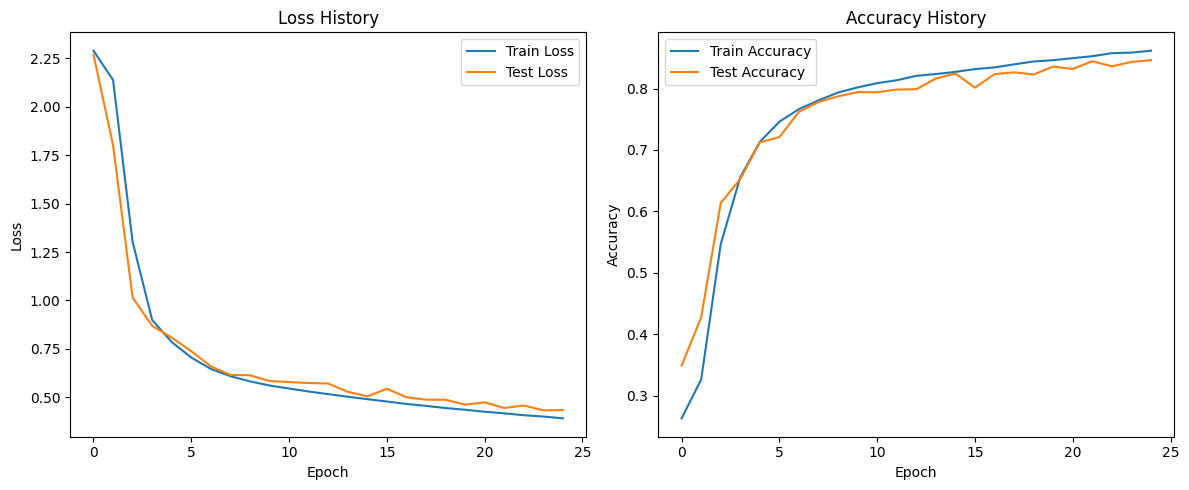

In [53]:
train_model([train_loader, test_loader],parameters, num_epochs=25, learning_rate=0.005)

In [54]:
if test_accuracies:
    print(f'Final test accuracy: {test_accuracies[-1]}')
else:
    print("No test accuracies recorded.")

Final test accuracy: 0.8462


## Visualization of the labels and predictions

In this section, you should visual one image from each class and show both the actual label and the predicted label for that image.

In [55]:
def predict(model, x, parameters):
    # Assuming x is a batch of images
    x = x.view(x.size(0), -1)  # Flatten the images if not already done
    outputs = model(x, parameters)
    _, predicted = torch.max(outputs, 1)
    return predicted


In [56]:
def visualize_predictions(dataset, model, parameters):
    figure, axes = plt.subplots(2, 5, figsize=(12, 6))  # Adjust size accordingly
    classes_seen = set()
    try:
        for images, labels in torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True):
            if labels.item() in classes_seen:
                continue
            axes[len(classes_seen) // 5, len(classes_seen) % 5].imshow(images[0].squeeze(), cmap='gray')
            predicted_label = predict(model, images, parameters)
            title = f"Actual: {dataset.classes[labels.item()]}\nPredicted: {dataset.classes[predicted_label.item()]}"
            axes[len(classes_seen) // 5, len(classes_seen) % 5].set_title(title)
            axes[len(classes_seen) // 5, len(classes_seen) % 5].axis('off')
            classes_seen.add(labels.item())
            if len(classes_seen) == 10:
                break
    except Exception as e:
        print(f"An error occurred: {e}")
    
    plt.tight_layout()
    plt.show()

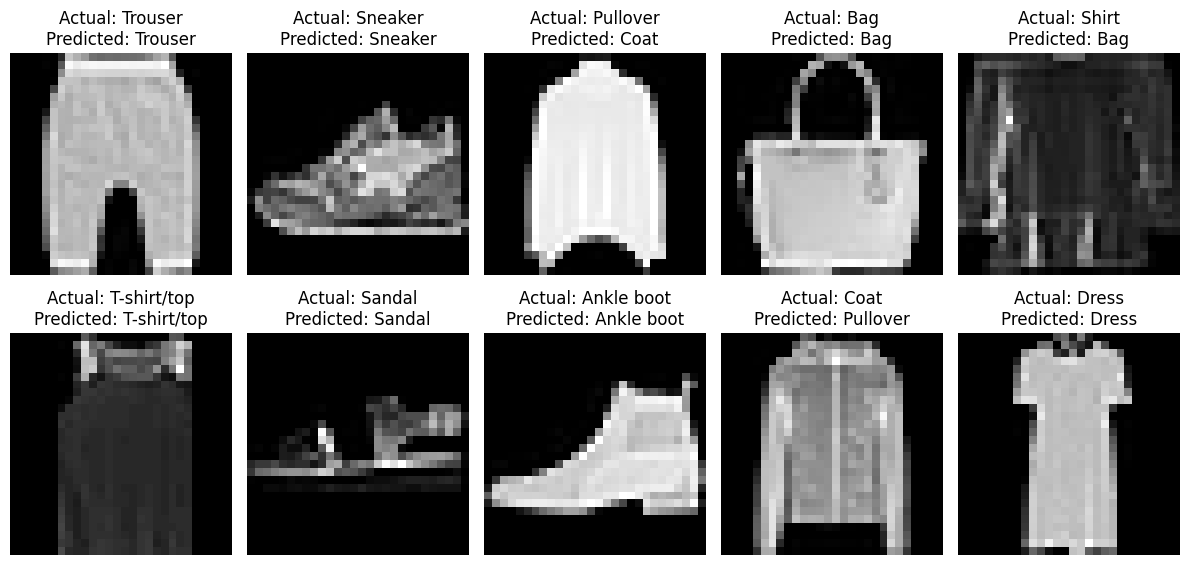

In [57]:
# Assume parameters are defined and model is your function
visualize_predictions(train_set, model, parameters)